# MNIST Vanilla
The purpose of this notebook is to act as a refresher for training a simple neural network on the mnist dataset.
We'll accomplish this without yet utilizing TensorFlow, although we'll cheat and grab the MNIST data from TensorFlow. This should end up looking very similar to the network defined in the first chapter of Neural Networks and Deep Learning at http://neuralnetworksanddeeplearning.com/

In [96]:
# Load up useful libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tasks
A lot of Deep Learning resources espouse how a simple neural network can be written in 70 lines, 30 lines, even 11 lines, but that does not do justice to information packed in each line of code. The major tasks include:
* Preparing the data (collecting, labeling, preprocessing, encoding, etc)
* Defining the network
* Training
* Tuning hyper-parameters

Each one of these tasks is monumental and the list is not exhaustive.

# Preparing the Data

First, the dataset needs to be downloaded and extracted. Then, it is divided into train/validation/test sets. Labels for the train/validation data must be one-hot encoded. All of this is handled via the read_data_sets function call.

In [97]:
''' 
Download the mnist dataset and validate the size/shape 
Note the image dimensions. Once we get to using TensorFlow, they will become 4D, rather than 2D: N x H x W x C, where:
    N = # of samples,
    H = rows/height of the image,
    W = columns/width of the image, and
    C = channels (colors) in the image
'''
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print(mnist.train.images.shape)
print(mnist.train.labels.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)


## Shuffling the Data
This handy function will later be used to shuffle the training data. It ensures that images and their labels will be shuffled in the same order. Another approach is to tuple your data and shuffle the tuples.

In [98]:
def shuffle(a, b):
    assert len(a) == len(b)
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)
    

Let's give it a shuffle in order to verify that it works as intended.

9


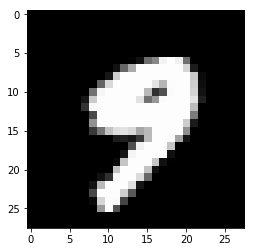

In [99]:
shuffle(mnist.train.images, mnist.train.labels)
# Sanity check that our shuffling is properly associating the labels with the images
img = np.reshape(np.copy(mnist.train.images), (55000, 28, 28))

plt.imshow(img[0], cmap='gray')
print(np.argmax(mnist.train.labels[0]))

One more for good measure:

4


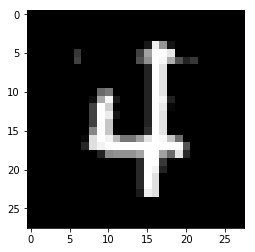

In [100]:
plt.imshow(img[1], cmap='gray')
print(np.argmax(mnist.train.labels[1]))

# Defining the Network
The structure of a basic neural network is as follows:
* An input layer and an output layer (dimensions match input data and number of labels, respectively
* One or more hidden layers 
* Weight matrices (the parameters)
* Bias matrices
* Feed Forward function
* Activation function for each layer (can be different for each layer, but we'll keep it the same for this example)
* Cost/Loss Function


## Activation Function and Cost Function

The activation function is used during the forward pass to add a non-linearity to the graph/network. After the forward pass, the cost function tells us how wrong the network was. Additionally, we'll need the derivative of each during the backpropagation phase of training.

Note about activation: here we use **sigmoid**, but we can return later to play with relu

Note about cost: For now, we're using **Mean Squared Error**, but there exist many cost functions, such as Cross Entropy, which behave better for categorization

In [101]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def cost(y, y_pred):
    return 0.5 * (1 / y.shape[0]) * np.sum(np.abs(y - y_pred) ** 2)

def cost_prime(y, y_pred):
    return y_pred - y

## Network Object
Store the network object in a simple python class called Network. It will be initialized by passing a list of integers defining each layer size. The network object itself will handle initializing the weights (basically, we just want them to be small, non-zero numbers).

In [102]:
class Network:
    
    def __init__(self, *layers):
        self.layers = [l for l in layers]
        self.W = [np.random.rand(layers[i], layers[i+1]) * 0.001 for i in range(len(layers) - 1)]
        self.B = [np.random.rand(1, layers[i+1]) for i in range(len(layers) - 1)]  # Input layer doesn't have bias
        
    def feedforward(self, x):
        a = x  # re-label input to simplify loop
        activations = [a]
        z_products = []
        for b, w in zip(self.B, self.W):
            z = np.dot(a, w) + b
            a = sigmoid(z)
            activations.append(a)
            z_products.append(z)
        return activations, z_products

Go ahead and give the network a spin. Note that position in the output & z array corresponds to the layer in the network where it was calculated (therefore, the last element in the array is the output of the network)

In [103]:
network = Network(784, 15, 10)
output, z = network.feedforward(mnist.train.images)
print(output[-1].shape)
print(cost(mnist.train.labels, output[-1]))

(55000, 10)
1.81265407302


# Training the Network

To train the network, we'll use Stochastic Gradient Descent (mini-batch). Achieving this will require shuffling the training data and labels and dividing the training data into mini-batches. Next, we have to do a forward pass on the network and then execute backpropagation to update the weights and biases of the network. 

In [149]:
class Network(Network):  # Extend the Network class defined above
    def test(self):
        # Stubbed. Gets defined further down
        return
    
    def train(self, images, labels, batch_size=200, learning_rate=0.01, epochs=10):
        assert len(images) == len(labels)
        
        for i in range(epochs):
            shuffle(images, labels)
            # Divide training data into batches
            img_batches = [images[i:i+batch_size] for i in range(0, len(images), batch_size)]
            label_batches = [labels[i:i+batch_size] for i in range(0, len(labels), batch_size)]
            n_batches = len(img_batches)

            training_cost = []
            for imgs, lbls in zip(img_batches, label_batches):
                a, z = self.feedforward(imgs)

                # Calculate Output Error
                dL = np.multiply((a[-1] - lbls),sigmoid_prime(z[-1]))

                # Update biases and weights for output layer using output error
                dBL = np.reshape(np.sum(dL, axis=0), (1,dL.shape[1]))
                dWL = np.dot(a[-2].T, dL)
                # Being verbose to show that we're building a list of deltas for each layer in the network (excluding input layer)
                dBl = [dBL]
                dWl = [dWL]
                dl = dL
                
                # Calculate Hidden Error
                for l in range(len(a) - 2, 0, -1):  # -1 for zero-indexing, -1 more because output layer already calculated
                    dl = np.multiply(np.dot(dl, self.W[l].T), sigmoid_prime(z[l-1]))
                    dBl.insert(0, np.reshape(np.sum(dl, axis=0), (1, dl.shape[1])))
                    dWl.insert(0, np.dot(a[l-1].T, dl))

                # Update weights and biases
                for j in range(len(self.W)):
                    self.W[j] -= (learning_rate / batch_size) * dWl[j]
                    self.B[j] -= (learning_rate / batch_size) * dBl[j]


            # Cost after training this epoch
            a, z = self.feedforward(images)
            training_cost.append(cost(labels, a[-1]))
            result = str(training_cost[-1])

            if (i + 1) % 5 == 0:
                result += ' ' + str(self.test()) +  ' / 10000'
            print(result)
        return training_cost
    

# Executing Training
With (mostly) everything defined, the network is ready to start training. First, let's define a simple network and see what its cost looks like

In [150]:
network = Network(784, 15, 10)
a, z = network.feedforward(mnist.train.images)
print(cost(mnist.train.labels, a[-1]))

1.95467500559


Finally, training can begin

In [136]:
network.train(mnist.train.images, mnist.train.labels, learning_rate=1, batch_size=200, epochs=10)

0.444991656377 None / 10000
0.387627743199
0.347096815885
0.285423758024
0.207681592376
0.155175530846 None / 10000
0.124628970265
0.106347775611
0.0952992923912
0.088065209104


[0.088065209103982078]

# Testing and Verification
Let's add a function that explicitly tells us how many images we've correctly labeled. As the network is just using MSE at the moment, we'll simply pick the label that has the highest confidence for each image.

In [152]:
class Network(Network):  # Extend the Network class defined above
    def test(self):
        img = mnist.test.images
        a, z = self.feedforward(img)
        a[-1].shape
        prediction = np.argmax(a[-1], axis=1)
        truth = np.argmax(mnist.test.labels, axis=1)
        result = np.sum([p == i for p, i in zip(prediction, truth)])
        return result


Now we can conveniently see both the cost and the test results while training. Let's go ahead and make a new network to show it off:

In [153]:
deep_network = Network(784,30,20,10)

In [154]:
deep_network.train(mnist.train.images, mnist.train.labels, learning_rate=1, batch_size=200, epochs=30)

0.450021870201
0.449917448743
0.449945072662
0.449952450361
0.449974470087 958 / 10000
0.449938790035
0.449912176299
0.449872756887
0.449956172318
0.449865490675 1135 / 10000
0.449881743108
0.449898807095
0.449913202814
0.449833784935
0.449845964966 1135 / 10000
0.449725057965
0.449628873177
0.44943997224
0.448952947942
0.446430387578 1582 / 10000
0.426607732767
0.408171267304
0.394224563864
0.381527540351
0.367544603882 3388 / 10000
0.357929807836
0.351677167675
0.342804469501
0.327001533472
0.312684037108 5116 / 10000


[0.3126840371078467]